In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
import emcee
import corner
import datetime

clight = 299792.458  # speed of light in km/s

In [13]:
# analysis parameters to be varied
sample = "fiducial"  # sample cuts to make (see below)
redshift = "nedfinal" # choices are "literature", "nedhost", "nedfinal", or "flowcorr" 
pecvel_unc = 150.0   # peculiar velocity uncertainty in km/s
distmode = "kinematic"  # use kinematic (q0,j0) or dynamic (Om,Ol) luminosity distance formula
use_median = False # set the Hubble residual and calibrator zeropoints relative to median rather than weighted mean

In [14]:
# cuts list: morphmin, morphmax, ebvmin, ebvmax, dm15min, dm15max, zmin, zmax, mwajmax, calibfile, hflowfile
samples = { "fiducial":   ( -9,  9, -9,   9,  -9, 1.5,   -9,    9,   9, "calibrators.dat", "hubbleflow.dat"), 
            "lowebv":     ( -9,  9, -9, 0.3,  -9, 1.5,   -9,    9,   9, "calibrators.dat", "hubbleflow.dat"),
            "spirals":    (1.9,  9, -9,   9,  -9, 1.5,   -9,    9,   9, "calibrators.dat", "hubbleflow.dat"),
            "lowmwaj":    ( -9,  9, -9,   9,  -9, 1.5,   -9,    9, 0.3, "calibrators.dat", "hubbleflow.dat"),
            "vlowmwaj":   ( -9,  9, -9,   9,  -9, 1.5,   -9,    9,0.15, "calibrators.dat", "hubbleflow.dat"),
            "restricted": (1.9,  9, -9, 0.3,  -9, 1.3,   -9,    9, 0.3, "calibrators.dat", "hubbleflow.dat"),
            "stringent":  (1.9,  9, -9, 0.3, 1.0, 1.2,   -9,    9,0.15, "calibrators.dat", "hubbleflow.dat"),
            "all":        ( -9,  9, -9,   9,  -9,   9,   -9,    9,   9, "calibrators.dat", "hubbleflow.dat"),
            "z02":        ( -9,  9, -9,   9,  -9, 1.5, 0.02,    9,   9, "calibrators.dat", "hubbleflow.dat"),
            "z025":       ( -9,  9, -9,   9,  -9, 1.5, 0.025,   9,   9, "calibrators.dat", "hubbleflow.dat"),
            "z03":        ( -9,  9, -9,   9,  -9, 1.5, 0.03,    9,   9, "calibrators.dat", "hubbleflow.dat"),
            "z07":        ( -9,  9, -9,   9,  -9, 1.5,   -9, 0.07,   9, "calibrators.dat", "hubbleflow.dat"),
            "z0207":      ( -9,  9, -9,   9,  -9, 1.5, 0.02, 0.07,   9, "calibrators.dat", "hubbleflow.dat"),
            "csp":        ( -9,  9, -9,   9,  -9, 1.5,   -9,    9,   9, "calibrators.dat", "hubbleflow_CSP.dat"),
            "cspall":     ( -9,  9, -9,   9,  -9,   9,   -9,    9,   9, "calibrators.dat", "hubbleflow_CSP.dat"),
            "cfa":        ( -9,  9, -9,   9,  -9, 1.5,   -9,    9,   9, "calibrators.dat", "hubbleflow_CfA.dat")
          }

morphmin, morphmax, ebvmin, ebvmax, dm15min, dm15max, zmin, zmax, mwajmax, calibfile, hflowfile = samples.get(sample) 

print(morphmin, morphmax, ebvmin, ebvmax, dm15min, dm15max, zmin, zmax, mwajmax, calibfile, hflowfile)

# data for calibrators
calib_datafile = calibfile  

# data for Hubble flow objects
hflow_datafile = hflowfile 

-9 9 -9 9 -9 1.5 -9 9 9 calibrators.dat hubbleflow.dat


In [15]:
# output plots will start with this prefix
pdf_basename = "diagnostic-" + sample

# create output file name

pdf_basename += "-z" + redshift
pdf_basename += "-sigcz=" + "{:.0f}".format(pecvel_unc)

if use_median:
    pdf_basename += '-median'

if distmode == "dynamic":
    pdf_basename += "-dynamic"

print(pdf_basename)

diagnostic-fiducial-znedfinal-sigcz=150


In [16]:
# function to convert peculiar velocity uncertainty (km/s) into magnitudes
#    this includes a small "correction factor" that accounts for the nonlinearity in a std LCDM cosmology
#    the correction factor is negligible at low redshift
def pverr2mag(z,pverr,correction=True):

    if correction:
        assert ((np.min(z) >= 0) and (np.max(z) <= 3)),"Correction factor defined for z=0-3 only"
        correction_coeffs = [1.00171318, 0.74494186, -0.97690614, 0.69153719, -0.28044894, 
                             0.06058092, -0.00537420]
        corrfactor = np.polyval(correction_coeffs[::-1],z)
    else:
        corrfactor = 1.0
        
    return 5.0/np.log(10.0)*pverr/299792.458/z*corrfactor

In [17]:
# function to return distance modulus mu(z) assuming H0=70
#   mode="dynamic" uses flat LCDM cosmology with Om=0.3, Om=0.7 (+ photons,neutrinos)
#   mode="kinematic" uses approximation with q0=-0.55, j0=1
#   negligible difference between these at low redshift
def distmod70(z,mode="dynamic"):
    if mode == "dynamic":
        cosmo = FlatLambdaCDM(H0=70.0, Om0=0.3)
        return 5.0 * np.log10(cosmo.luminosity_distance(z)/u.Mpc) + 25.0
    elif mode == "kinematic":
        q0 = -0.55
        j0 = 1.0
        return 5.0 * np.log10(299792.458*z/70.0 *
                              (1 + (1 - q0)*z/2.0 
                               - (1 - q0 - 3*q0**2 + j0)*(z**2)/6.0)) + 25.0
    else:
        raise ValueError("Undefined mode")    

In [18]:
# calibrators
calib_readin = np.genfromtxt(calib_datafile, dtype=None, 
                             names="SN,mag,magerr,mu,muerr,absM,absMerr,ebv,dm15,host,hostmorph"
                                   + ",morph,mwaj,kcorr,ref,sample")

# get sample cuts, but don't apply them
good = (  (calib_readin["ebv"] >= ebvmin) & (calib_readin["ebv"] <= ebvmax)
        & (calib_readin["morph"] >= morphmin) & (calib_readin["morph"] <= morphmax)
        & (calib_readin["dm15"] >= dm15min) & (calib_readin["dm15"] <= dm15max)
        & (calib_readin["mwaj"] <= mwajmax))
bad = ~good

calib_unc = calib_readin["absMerr"]
calib_data = calib_readin["absM"]
calib_SN = np.char.decode(calib_readin["SN"])
ncalib = len(calib_data[good])

calib_wtmean = np.average(calib_data[good],weights=calib_unc[good]**(-2))
cpull = (calib_data - calib_wtmean)/calib_unc
cchisq = np.sum(cpull[good]**2)
sigcalib = np.std(calib_data[good])

print(ncalib,calib_wtmean,cchisq,sigcalib)

9 -18.5235965203 55.2311219901 0.159788826693


In [19]:
# sanity checks of the file
testabsM = calib_readin["mag"] - calib_readin["mu"]
testerr = np.sqrt(calib_readin["magerr"]**2 + calib_readin["muerr"]**2) 

if np.max(np.abs(testabsM-calib_data)) > 1e-10:
    print("calibrator absolute magnitude doesn't match calculated value?!")

if np.max(np.abs(testerr-calib_unc)) > 5e-4:
    print("calibrator absolute magnitude uncertainty doesn't match calculated value?!")
    
# no output if things are okay

In [20]:
## Hubble flow objects
hflow_readin = np.genfromtxt(hflow_datafile,dtype=None,
                             names="SN,zlit,zned,znederr,znedfinal,znedfinalerr,zflowcorrected," +
                             "mag,magerr,ebv,dm15,host,hostmorph,morph,mwaj,kcorr,survey")

if redshift == "literature":
    zobstr = "zlit"
elif redshift == "nedhost":
    zobstr = "zned"
    zerrstr = "znederr"
elif redshift == "nedfinal":
    zobstr = "znedfinal"
    zerrstr = "znedfinalerr"
elif redshift == "flowcorr":
    zobstr = "zflowcorrected"
    zerrstr = "znedfinalerr"
else: 
    raise ValueError("Undefined redshift type")
    
# get sample cuts but don't apply them
hgood = (  (hflow_readin["ebv"] >= ebvmin) & (hflow_readin["ebv"] <= ebvmax)
         & (hflow_readin["morph"] >= morphmin) & (hflow_readin["morph"] <= morphmax)
         & (hflow_readin["dm15"] >= dm15min) & (hflow_readin["dm15"] <= dm15max) 
         & (hflow_readin[zobstr] >= zmin) & (hflow_readin[zobstr] <= zmax) 
         & (hflow_readin["mwaj"] <= mwajmax) )
hbad = ~hgood

hflow_data = hflow_readin["mag"]
hflow_ptunc = hflow_readin["magerr"]
nhflow = len(hflow_data[hgood])

hflow_zobs = hflow_readin[zobstr]
if redshift == "literature":
    hflow_zerr = 0.
else:
    hflow_zerr = hflow_readin[zerrstr]
    
hflow_verr = hflow_zerr * clight

# total z error is redshift measurement uncertainty plus peculiar velocity uncertainty
hflow_totverr = np.sqrt(hflow_verr**2 + pecvel_unc**2)
hflow_totzerr = hflow_totverr / clight

# convert z error into magnitudes
hflow_pvmagerr = pverr2mag(hflow_zobs,hflow_totverr)
hflow_unc = np.sqrt(hflow_ptunc**2 + hflow_pvmagerr**2)

In [21]:
# for the likelihood function, we pass in the Hubble flow data as the absolute magnitude assuming H0=70
# the best fit H0 is based on the difference between these and the calibrator absolute magnitudes
hflow_mu70 = distmod70(hflow_zobs,mode=distmode)
hflow_M70 = hflow_data - hflow_mu70

# calculate Hubble residuals
hflow_wtmeanM = np.average(hflow_M70[hgood],weights=hflow_unc[hgood]**(-2))
hr = hflow_M70 - hflow_wtmeanM
# use median?
if use_median:
    hr -= np.median(hr[hgood])

hpull = hr/hflow_unc
hchisq = np.sum(hpull[hgood]**2)
sighr = np.std(hr[hgood])

print(nhflow, hflow_wtmeanM, hchisq, sighr)

27 -18.6154166958 62.8058062431 0.105540612105


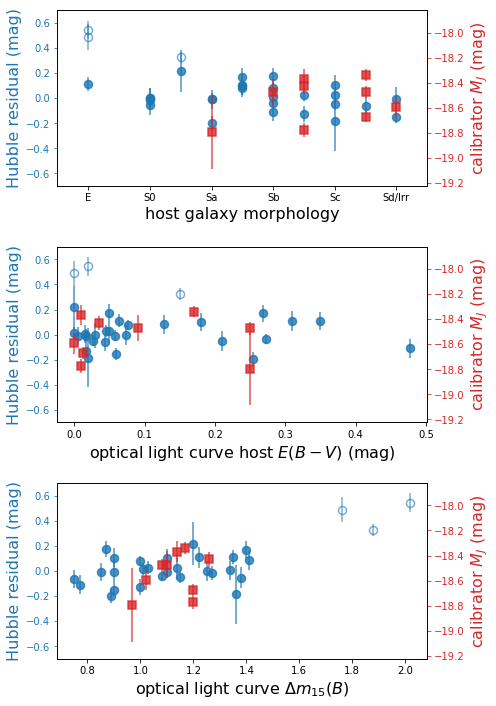

In [23]:
# diagnostic plots comparing calibrators and Hubble flow objects

calib_ebv = calib_readin["ebv"]
calib_dm15 = calib_readin["dm15"]
calib_morph = calib_readin["morph"]

hflow_ebv = hflow_readin["ebv"]
hflow_dm15 = hflow_readin["dm15"]
hflow_morph = hflow_readin["morph"]

figall_diag = plt.figure(figsize=(7,10))

ylim = np.array([-0.7,0.7])
calib_wtmeanM = np.average(calib_data,weights=calib_unc**(-2))

if use_median:
    calib_zp = np.median(calib_data)
else:
    calib_zp = calib_wtmeanM

plt.subplot2grid((3,1), (0,0))
plt.errorbar(hflow_morph[hbad],hr[hbad],yerr=hflow_unc[hbad],ms=8.,mew=1.5
             ,marker='o',linestyle='none',alpha=0.6,color='C0',fillstyle='none')
plt.errorbar(hflow_morph[hgood],hr[hgood],yerr=hflow_unc[hgood],ms=8.,mew=1.5
             ,marker='o',linestyle='none',alpha=0.8,label='Hubble flow',color='C0')
plt.ylabel(r"Hubble residual (mag)",fontsize=16,color='C0')
plt.xlabel(r"host galaxy morphology", fontsize=16)
plt.ylim(ylim)
plt.tick_params('y', colors='C0')
ax2 = plt.twinx()
ax2.errorbar(calib_morph[bad],calib_data[bad],yerr=calib_unc[bad],ms=8.,mew=1.5
             ,marker='s',linestyle='none',color='C3',alpha=0.6,fillstyle='none')
ax2.errorbar(calib_morph[good],calib_data[good],yerr=calib_unc[good],ms=8.,mew=1.5
             ,marker='s',linestyle='none',color='C3',alpha=0.8,label='calibrator')
plt.ylabel(r"calibrator $M_J$ (mag)", fontsize=16, color='C3')
ax2.tick_params('y', colors='C3')
plt.xlim([-0.5,5.5])
plt.ylim(ylim+calib_zp)
plt.xticks([0,1,2,3,4,5],['E','S0','Sa','Sb','Sc','Sd/Irr'])

plt.subplot2grid((3,1), (1,0))
plt.scatter(hflow_ebv,hr,marker='')
plt.errorbar(hflow_ebv[hbad],hr[hbad],yerr=hflow_unc[hbad],ms=8.,mew=1.5
             ,marker='o',linestyle='none',alpha=0.6,color='C0',fillstyle='none')
plt.errorbar(hflow_ebv[hgood],hr[hgood],yerr=hflow_unc[hgood],ms=8.,mew=1.5
             ,marker='o',linestyle='none',alpha=0.8,label='Hubble flow',color='C0')
plt.ylabel(r"Hubble residual (mag)",fontsize=16,color='C0')
plt.xlabel(r"optical light curve host $E(B-V)$ (mag)", fontsize=16)
plt.ylim(ylim)
plt.tick_params('y', colors='C0')
ax2 = plt.twinx()
ax2.errorbar(calib_ebv[bad],calib_data[bad],yerr=calib_unc[bad],ms=8.,mew=1.5
             ,marker='s',linestyle='none',color='C3',alpha=0.6,fillstyle='none')
ax2.errorbar(calib_ebv[good],calib_data[good],yerr=calib_unc[good],ms=8.,mew=1.5
             ,marker='s',linestyle='none',color='C3',alpha=0.8,label='calibrator')
plt.ylabel(r"calibrator $M_J$ (mag)", fontsize=16, color='C3')
ax2.tick_params('y', colors='C3')
plt.ylim(ylim+calib_zp)

plt.subplot2grid((3,1), (2,0))
plt.scatter(hflow_dm15,hr,marker='')
plt.errorbar(hflow_dm15[hbad],hr[hbad],yerr=hflow_unc[hbad],ms=8.,mew=1.5
             ,marker='o',linestyle='none',alpha=0.6,fillstyle='none',color='C0')
plt.errorbar(hflow_dm15[hgood],hr[hgood],yerr=hflow_unc[hgood],ms=8.,mew=1.5
             ,marker='o',linestyle='none',alpha=0.8,label='Hubble flow',color='C0')
plt.ylabel(r"Hubble residual (mag)",fontsize=16,color='C0')
plt.xlabel(r"optical light curve $\Delta m_{15}(B)$", fontsize=16)
plt.ylim(ylim)
plt.tick_params('y', colors='C0')
ax2 = plt.twinx()
ax2.errorbar(calib_dm15[bad],calib_data[bad],yerr=calib_unc[bad],ms=8.,mew=1.5
             ,marker='s',linestyle='none',color='C3',alpha=0.8,fillstyle='none')
ax2.errorbar(calib_dm15[good],calib_data[good],yerr=calib_unc[good],ms=8.,mew=1.5
             ,marker='s',linestyle='none',color='C3',alpha=0.8,label='calibrator')
plt.ylabel(r"calibrator $M_J$ (mag)", fontsize=16, color='C3')
ax2.tick_params('y', colors='C3')
plt.ylim(ylim+calib_zp)



plt.tight_layout()
plt.savefig(pdf_basename+".pdf",bbox_inches="tight")
plt.show()